# Análise de dados

In [1]:
# Configurações
DATA_CSV = 'TR-SLD_v1-0b_shuffled_balanced.csv'
DATA_FRMT = 'wav'
DATASET = 'SLD_v1-0b'
GROUP = 'train'
RANDOM_SAMPLES = 500  # Use None to load all dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import os
import glob
import pandas
import tqdm
import random
from tqdm import tqdm_notebook
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [3]:
%matplotlib inline 
color = sns.color_palette()
py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [4]:
data = pandas.read_csv(DATA_CSV)
data.columns = ['file_path', 'label']

In [5]:
# Fix the path
data['file_path'] = data['file_path'].apply(lambda fp: fp[23:])

In [6]:
data.head()

file_path   label
0  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch
1  train/de\de_f_2825f\de_f_2825f__rmx__r16000__n...  deutch
2  train/de\de_m_4d099\de_m_4d099__rmx__r16000__n...  deutch
3  train/de\de_m_ce41a\de_m_ce41a__rmx__r16000__n...  deutch
4  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch

In [7]:
def load_wav_file(path):
    sr, b = wavfile.read(path)
    return sr, b

In [8]:
# Load data
if not RANDOM_SAMPLES:
    # Samples == data
    wavs = dict()
    wavs['time_series'] = []
    wavs['sample_rate'] = []
    for path in data['file_path']:
        sr, b = wavfile.read(path)
        wavs['time_series'].append(b)
        wavs['sample_rate'].append(sr)
    samples = pandas.DataFrame(wavs, columns = ['file_path', 'time_series', 'sample_rate'])
    samples['file_path'] = data['file_path']
else:
    # Load #RANDOM_SAMPLES samples
    samples = dict()
    samples['time_series'] = []
    samples['sample_rate'] = []
    df_samples = data.sample(RANDOM_SAMPLES)
    for path in df_samples['file_path']:
        sr, b = wavfile.read(path)
        samples['sample_rate'].append(sr)
        samples['time_series'].append(b)
    df_samples['sample_rate'] = samples['sample_rate']
    df_samples['time_series'] = samples['time_series']
    samples = df_samples
    
samples['label'] = data['label']
samples['nframes'] = samples['time_series'].apply(len)
# The file name is an abreviation
## WARNING: Be careful when changing the number of characters selected, because the analysis of 
## speakers was made based on the name of file
samples['file_name'] = samples['file_path'].apply(lambda p: p.split(os.sep)[-1])
samples.head(40)

file_path       label  \
58144  train/es\es_f_7b894\es_f_7b894__rmx__r16000__n...     spanish   
4909   train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...      deutch   
63353  train/es\es_m_d5b91\es_m_d5b91__rmx__r16000__n...     spanish   
45208  train/pt\pt_m_6c435\pt_m_6c435__rmx__r16000__n...  portuguese   
35390  train/fr\fr_m_97ed5\fr_m_97ed5__rmx__r16000__n...      french   
7690   train/de\de_m_d2253\de_m_d2253__rmx__r16000__n...      deutch   
55102  train/es\es_m_f16e9\es_m_f16e9__rmx__r16000__n...     spanish   
40076  train/pt\pt_m_4453f\pt_m_4453f__rmx__r16000__n...  portuguese   
1583   train/de\de_f_5d2e7\de_f_5d2e7__rmx__r16000__n...      deutch   
35814  train/fr\fr_m_59472\fr_m_59472__rmx__r16000__n...      french   
25482  train/en\en_f_9a47e\en_f_9a47e__rmx__r16000__n...     english   
44249  train/pt\pt_f_5d3e4\pt_f_5d3e4__rmx__r16000__n...  portuguese   
58731  train/es\es_f_56ef0\es_f_56ef0__rmx__r16000__n...     spanish   
19897  train/en\en_f_7701e\en_f_7701e__rmx__r16000__n...     english   
56288  train/es\es_m_30686\es_m_30686__rmx__r16000__n...     spanish   
28441  train/fr\fr_m_59472\fr_m_59472__rmx__r16000__n...      french   
23815  train/en\en_f_31da4\en_f_31da4__rmx__r16000__n...     english   
52173  train/pt\pt_f_52518\pt_f_52518__rmx__r16000__n...  portuguese   
9960   train/de\de_f_bce24\de_f_bce24__rmx__r16000__n...      deutch   
11135  train/de\de_m_50229\de_m_50229__rmx__r16000__n...      deutch   
27293  train/fr\fr_f_d5304\fr_f_d5304__rmx__r16000__n...      french   
14107  train/en\en_f_25836\en_f_25836__rmx__r16000__n...     english   
56006  train/es\es_m_b5327\es_m_b5327__rmx__r16000__n...     spanish   
8106   train/de\de_f_f856a\de_f_f856a__rmx__r16000__n...      deutch   
60474  train/es\es_f_56ef0\es_f_56ef0__rmx__r16000__n...     spanish   
38114  train/fr\fr_m_59472\fr_m_59472__rmx__r16000__n...      french   
11996  train/de\de_f_f856a\de_f_f856a__rmx__r16000__n...      deutch   
53247  train/es\es_f_68e1d\es_f_68e1d__rmx__r16000__n...     spanish   
26673  train/fr\fr_m_97ed5\fr_m_97ed5__rmx__r16000__n...      french   
24132  train/en\en_f_386ee\en_f_386ee__rmx__r16000__n...     english   
2383   train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...      deutch   
19499  train/en\en_m_3a8f3\en_m_3a8f3__rmx__r16000__n...     english   
57326  train/es\es_m_4d7e5\es_m_4d7e5__rmx__r16000__n...     spanish   
44499  train/pt\pt_f_6d7fe\pt_f_6d7fe__rmx__r16000__n...  portuguese   
43696  train/pt\pt_f_b639c\pt_f_b639c__rmx__r16000__n...  portuguese   
20606  train/en\en_f_fff98\en_f_fff98__rmx__r16000__n...     english   
59973  train/es\es_f_db16e\es_f_db16e__rmx__r16000__n...     spanish   
57218  train/es\es_m_9d824\es_m_9d824__rmx__r16000__n...     spanish   
37850  train/fr\fr_m_46787\fr_m_46787__rmx__r16000__n...      french   
64758  train/es\es_f_68e1d\es_f_68e1d__rmx__r16000__n...     spanish   

       sample_rate                                        time_series  \
58144        16000  [-257, -993, 586, -120, -1338, 974, -1026, -19...   
4909         16000  [-263, 151, 552, 1012, 1450, 1800, 2169, 2838,...   
63353        16000  [-536, -587, -623, -583, -568, -593, -713, -98...   
45208        16000  [206, -257, -768, -837, -334, 102, 141, -160, ...   
35390        16000  [-12, -12, -10, -11, -9, -9, -10, -13, -13, -1...   
7690         16000  [-98, -32, 7, -29, -108, -133, -148, -127, -60...   
55102        16000  [-799, -434, -554, -836, -822, -414, 130, 522,...   
40076        16000  [185, -46, 296, 577, 334, 326, 756, 433, 15, -...   
1583         16000  [-4, -9, -5, 2, 3, 11, 2, -19, -25, -27, -19, ...   
35814        16000  [600, -638, -396, 35, 1808, 1265, -1917, -927,...   
25482        16000  [101, 88, 59, 57, 45, 56, 67, 33, -2, -33, -27...   
44249        16000  [-3223, -3509, -4172, -4324, -3612, -2904, -27...   
58731        16000  [48857088, 42139648, 31555584, 22183936, 27099...   
19897        16000  [-17, -13, -12, -13, -13, -14, -9, -10, -13, -...   

In [9]:
data['file_name'] = data['file_path'].apply(lambda p: p.split(os.sep)[-1][:-4][:24])
full_names = [x.split(os.sep)[-1] for x in data['file_path']]
# Data augmentation
def gftrv(full_n, feature):
    x = full_n.split(feature, 1)
    if len(x) > 1:
        if feature == 'lp':
            return x[1].split('_')[0]
        return x[1].split('_')[1]
    return None
speeds = [gftrv(x, '_sp') for x in full_names]
pitches = [gftrv(x, '_pt') for x in full_names]
noises = [gftrv(x, '_ns') for x in full_names]
low_pass = [gftrv(x, '_lp') for x in full_names]
data['speed_changing'] = speeds
data['pitch_changing'] = pitches
data['noise_add'] = noises
data['low_pass'] = low_pass
data['augmented_data'] = list(map(lambda x: x[0] is not None or x[1] is not None or x[2] is not None or x[3] is not None,
                                 list(zip(speeds, pitches, noises, low_pass))))
export_csv = data.to_csv (r'[DF]{}'.format(DATA_CSV), index = None, header=True) 


In [10]:
data.head()

file_path   label  \
0  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch   
1  train/de\de_f_2825f\de_f_2825f__rmx__r16000__n...  deutch   
2  train/de\de_m_4d099\de_m_4d099__rmx__r16000__n...  deutch   
3  train/de\de_m_ce41a\de_m_ce41a__rmx__r16000__n...  deutch   
4  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch   

                  file_name speed_changing pitch_changing noise_add low_pass  \
0  de_f_0809f__rmx__r16000_           0.95           None      None     None   
1  de_f_2825f__rmx__r16000_           None           50.0      None     None   
2  de_m_4d099__rmx__r16000_           0.85           None      None     None   
3  de_m_ce41a__rmx__r16000_           0.80           None      None     None   
4  de_f_0809f__rmx__r16000_           None           None  ambiance     None   

   augmented_data  
0            True  
1            True  
2            True  
3            True  
4            True

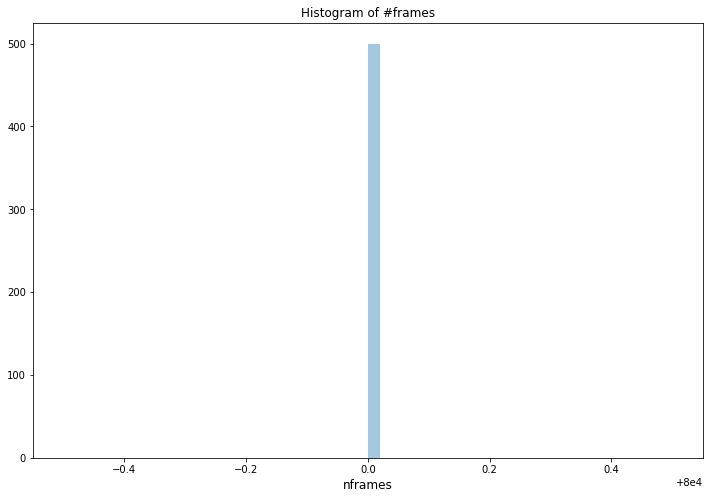

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samples.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

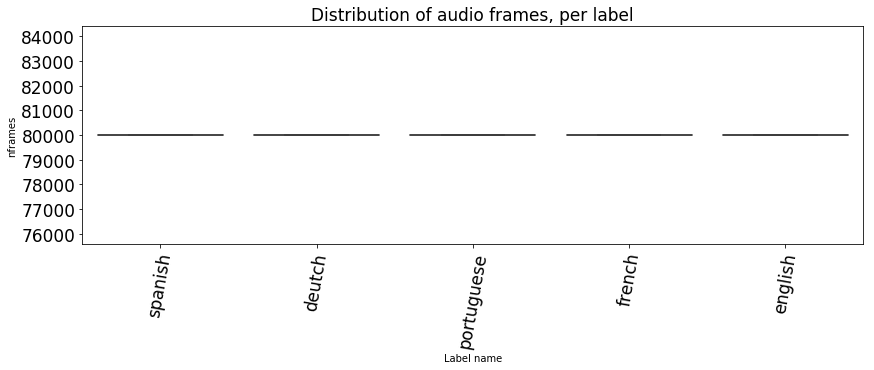

In [12]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=samples)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

In [13]:
temp = data.sort_values(by='label')
temp.head()

file_path   label  \
0     train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch   
8725  train/de\de_m_ab485\de_m_ab485__rmx__r16000__n...  deutch   
8726  train/de\de_f_26ddc\de_f_26ddc__rmx__r16000__n...  deutch   
8727  train/de\de_f_8e8ed\de_f_8e8ed__rmx__r16000__n...  deutch   
8728  train/de\de_f_f856a\de_f_f856a__rmx__r16000__n...  deutch   

                     file_name speed_changing pitch_changing noise_add  \
0     de_f_0809f__rmx__r16000_           0.95           None      None   
8725  de_m_ab485__rmx__r16000_           None           50.0      None   
8726  de_f_26ddc__rmx__r16000_           None           None  ambiance   
8727  de_f_8e8ed__rmx__r16000_           1.20           None      None   
8728  de_f_f856a__rmx__r16000_           None           50.0      None   

     low_pass  augmented_data  
0        None            True  
8725     None            True  
8726     None            True  
8727     None            True  
8728     None            True

In [14]:
def get_index_label(label):
    for i, ins in enumerate(temp['label']):
        if ins == label:
            return i
get_index_label('english')

13097

Total number of labels in training data :  5
Labels are :  ['deutch' 'english' 'french' 'portuguese' 'spanish']


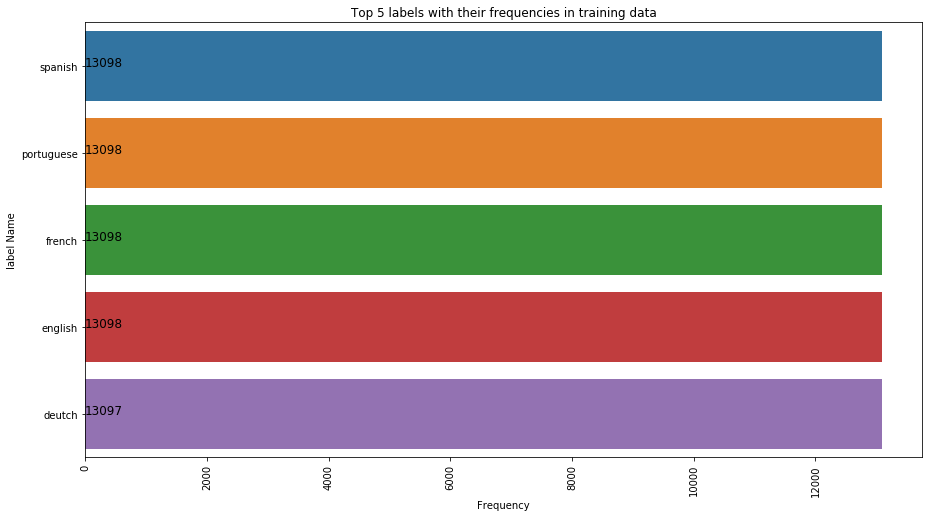

In [15]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [16]:
data['gender'] = data['file_name'].apply(lambda n: n.split('_')[1])

## Instâncias por idioma

In [17]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by language')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por quantidade de frames (amostras)

In [18]:
temp = samples['nframes'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por sample rate (amostras)

In [19]:
temp = samples['sample_rate'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por duração total (amostras)

In [20]:
def duration(nframes, sample_rate):
    return sample_rate / nframes

In [21]:
samples['duration'] = pandas.DataFrame([duration(sr, b) for sr, b
                                        in zip(samples['sample_rate'], 
                                               samples['nframes'])])
temp = samples['duration'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by duration')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por gênero

In [22]:
temp = data['gender'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Gender')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por contagem de locutores

In [23]:
speakers_count = dict()
for lang in data['label']:
    speakers_count[lang] = 0
counted = set()
for lang, fname in zip(data['label'], data['file_name']):
    if fname not in counted:
        speakers_count[lang] += 1
        counted.add(fname)
        
df_spk = pandas.DataFrame(data=list(zip(speakers_count.keys() ,speakers_count.values())), 
                          columns=['label', 'Speakers (count)'])
df_spk.head()

label  Speakers (count)
0      deutch                28
1     english                28
2      french                28
3  portuguese                29
4     spanish                28

In [24]:
temp = df_spk['Speakers (count)']
labels = df_spk['label']
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Speaker (count)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por locutores

count
label  file_name                      
deutch de_f_0809f__rmx__r16000_    485
       de_f_1996a__rmx__r16000_    465
       de_f_26ddc__rmx__r16000_    487
       de_f_2825f__rmx__r16000_    467
       de_f_40479__rmx__r16000_    444

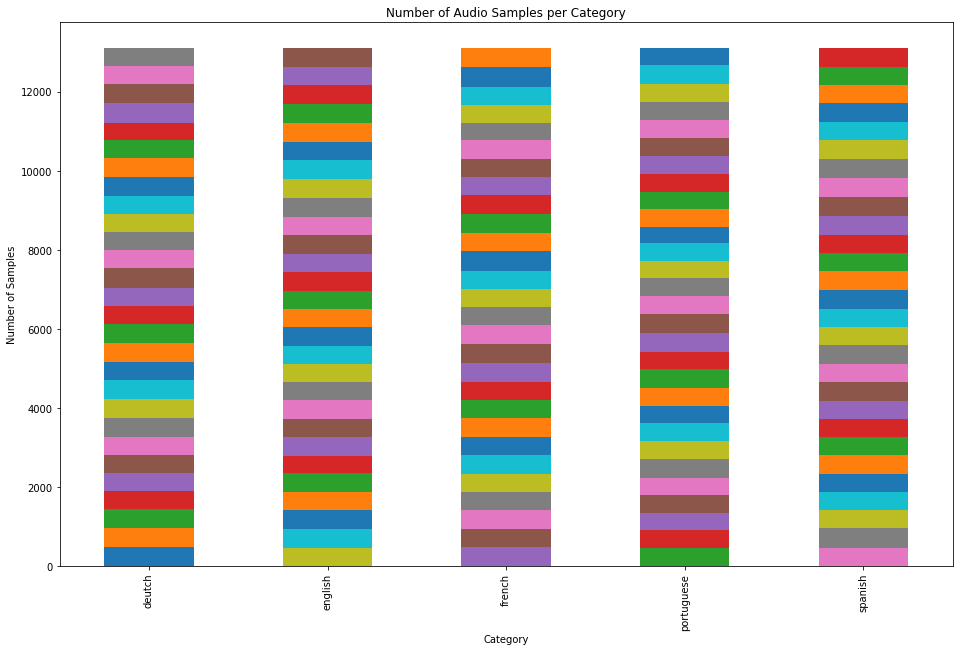

In [25]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['file_name']), 
                        columns=['count', 'label', 'file_name'])
category_group = temp.groupby(['label', 'file_name']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
plot.get_legend().remove()
category_group.head()

## Instâncias por idioma e gênero

count
label      gender       
deutch     f        6575
           m        6522
english    f        6511
           m        6587
french     f        6562
           m        6536
portuguese f        5895
           m        7203
spanish    f        6508
           m        6590

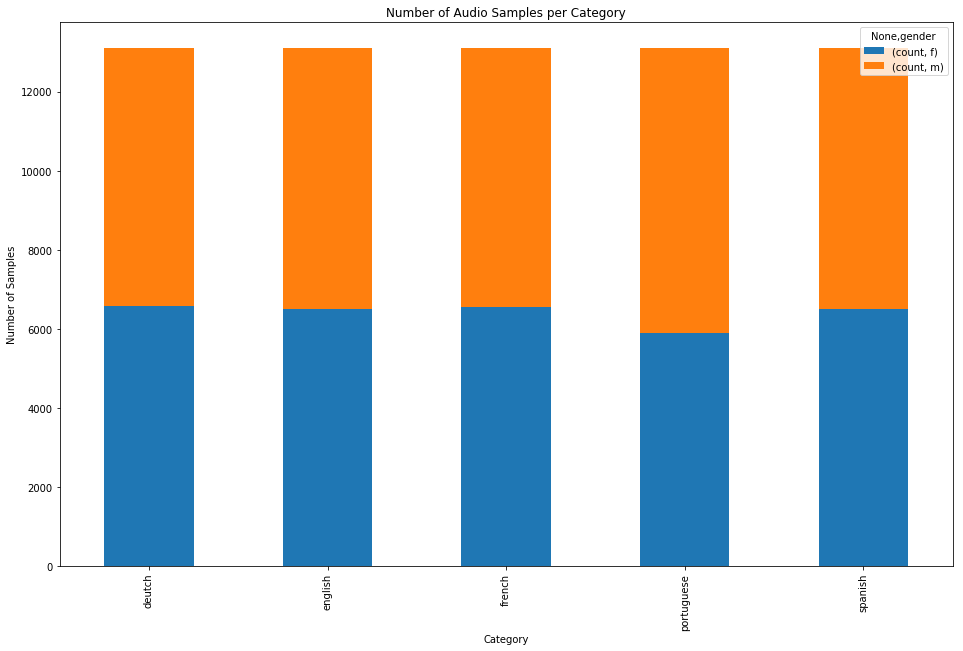

In [26]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['gender']), 
                        columns=['count', 'label', 'gender'])
category_group = temp.groupby(['label', 'gender']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

## Instâncias por _data augmentation_

In [27]:
temp = data['augmented_data'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Data Augmentation')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por idioma e _data augmentation_

count
label      augmented_data       
deutch     False             617
           True            12480
english    False             618
           True            12480
french     False             619
           True            12479
portuguese False             616
           True            12482
spanish    False             620
           True            12478

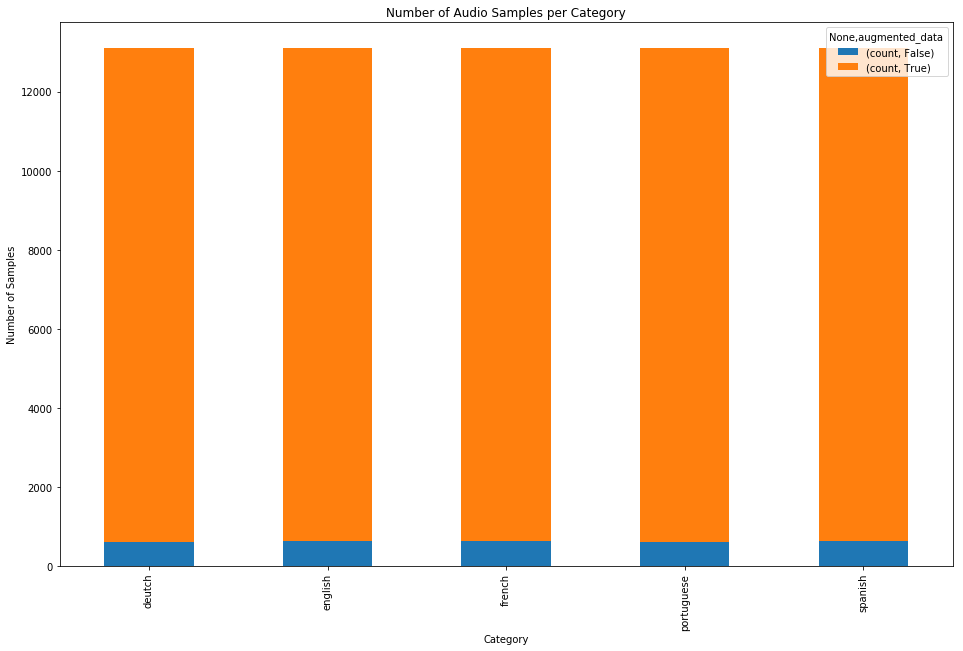

In [28]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['augmented_data']), 
                        columns=['count', 'label', 'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

count  speed_changing  pitch_changing  noise_add  \
label   augmented_data                                                     
deutch  False             617               0               0          0   
        True            12480            5061            4949       2470   
english False             618               0               0          0   
        True            12480            5044            4958       2478   
french  False             619               0               0          0   

                        low_pass  
label   augmented_data            
deutch  False                  0  
        True                   0  
english False                  0  
        True                   0  
french  False                  0

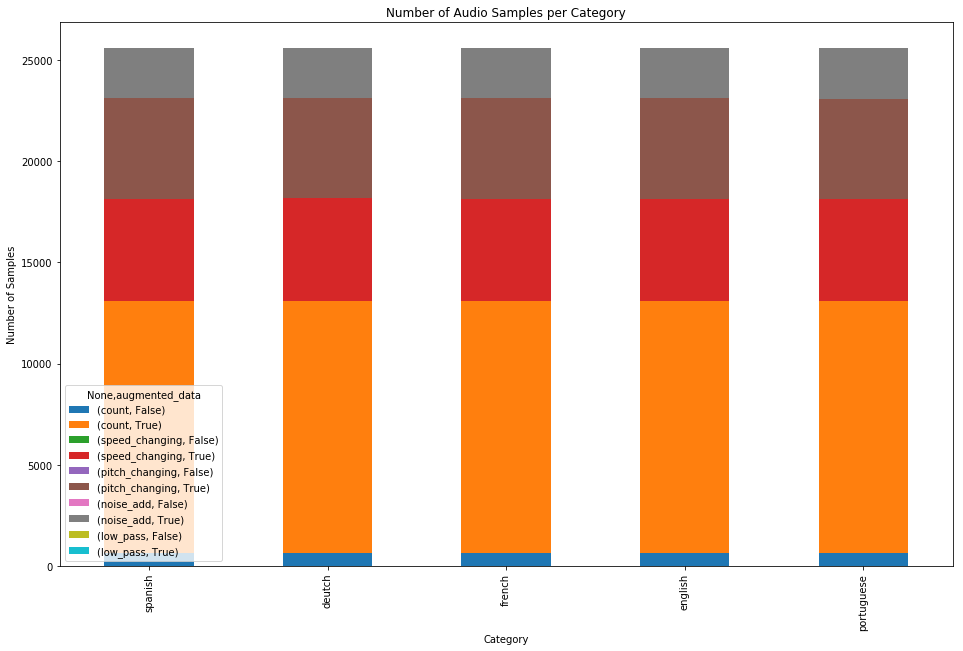

In [29]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['speed_changing'],
                            data['pitch_changing'], data['noise_add'], data['low_pass'], data['augmented_data']), 
                        columns=['count', 'label', 'speed_changing', 'pitch_changing', 'noise_add', 'low_pass',
                                'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
#category_group = category_group[category_group.speed_changing != 0]
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group.head()

## Waveform 

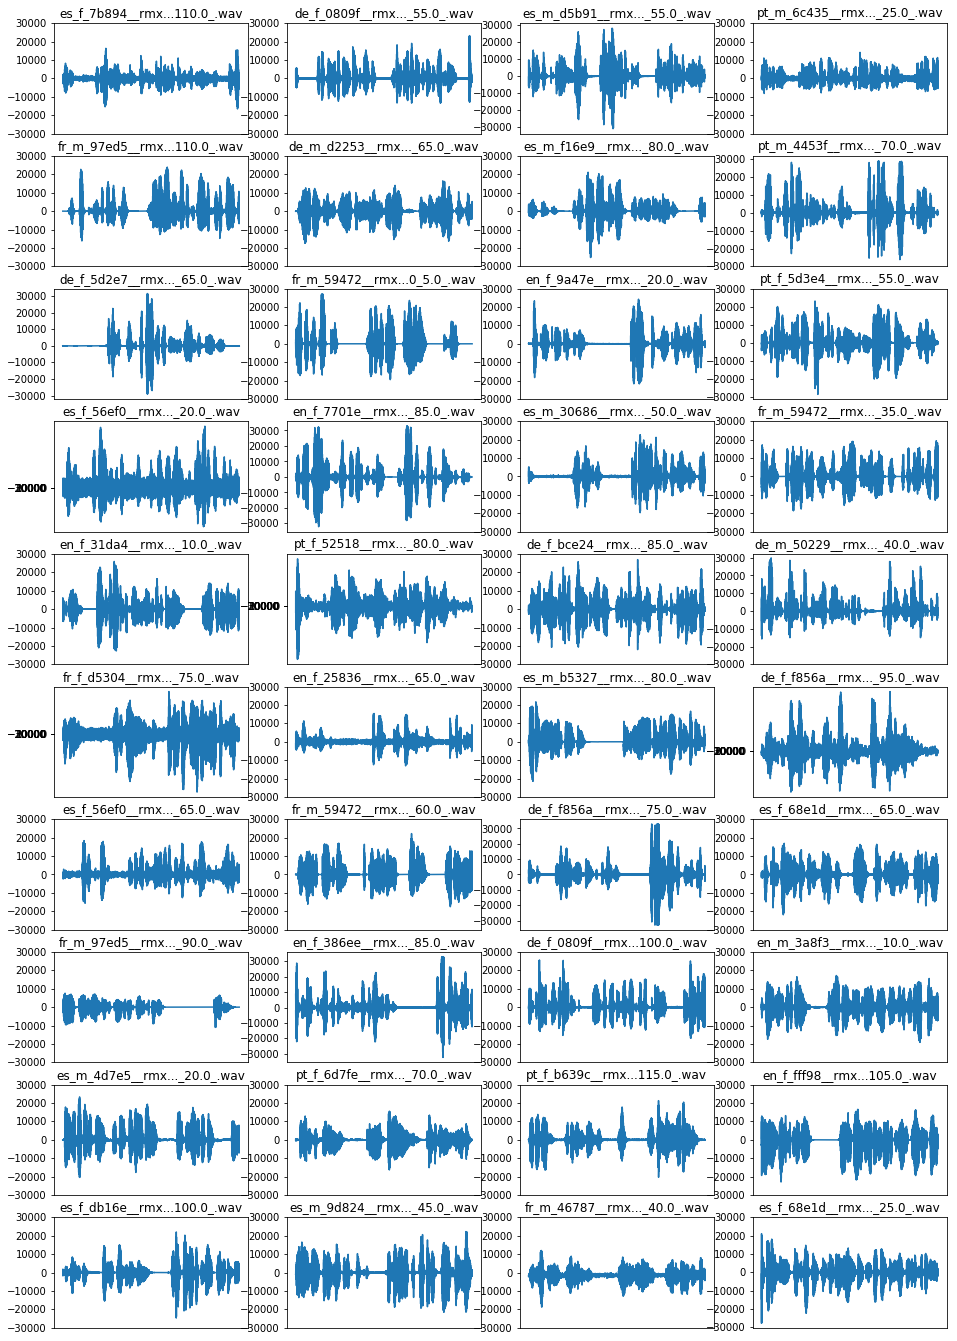

In [30]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
    ax[i//4, i%4].get_yaxis().set_ticks([-30000, -20000, -10000, 0, 10000, 20000, 30000])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [31]:
sr, b = wavfile.read(data['file_path'][0])

In [32]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

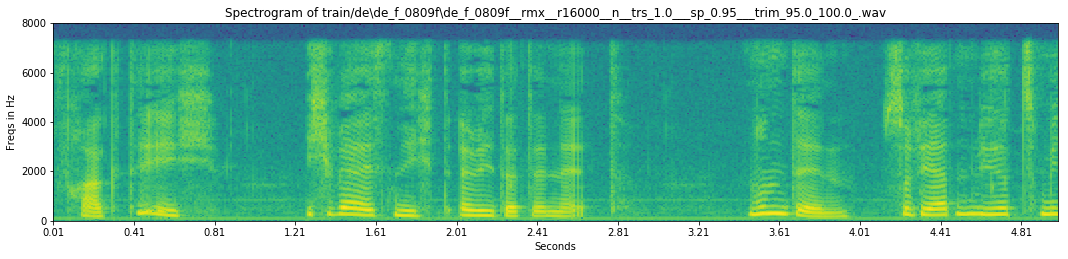

In [33]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['file_path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [34]:
print("Size of training data", data.shape)

Size of training data (65489, 9)


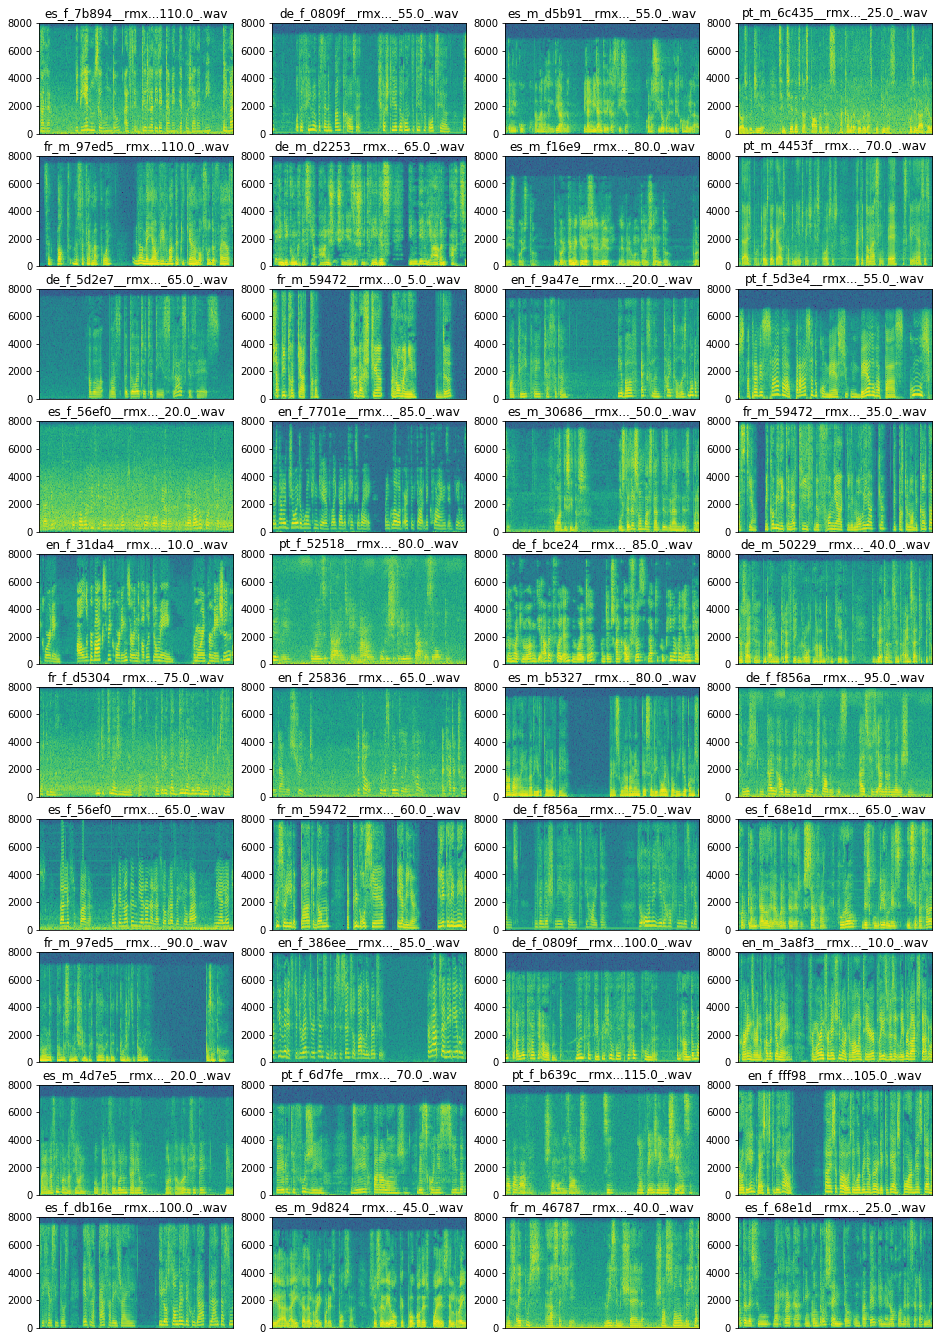

In [35]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [36]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

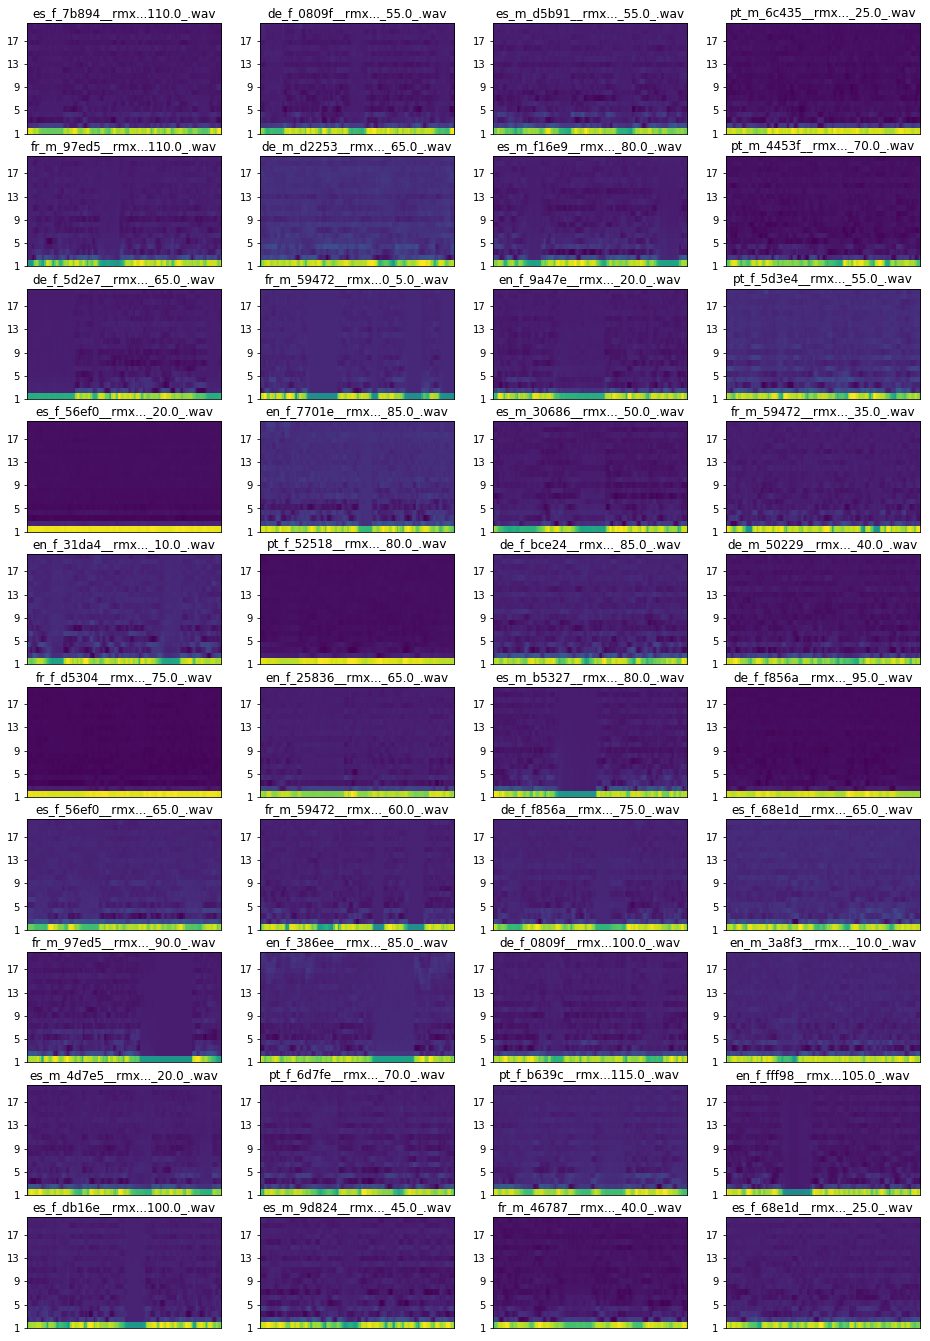

In [37]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta

In [38]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

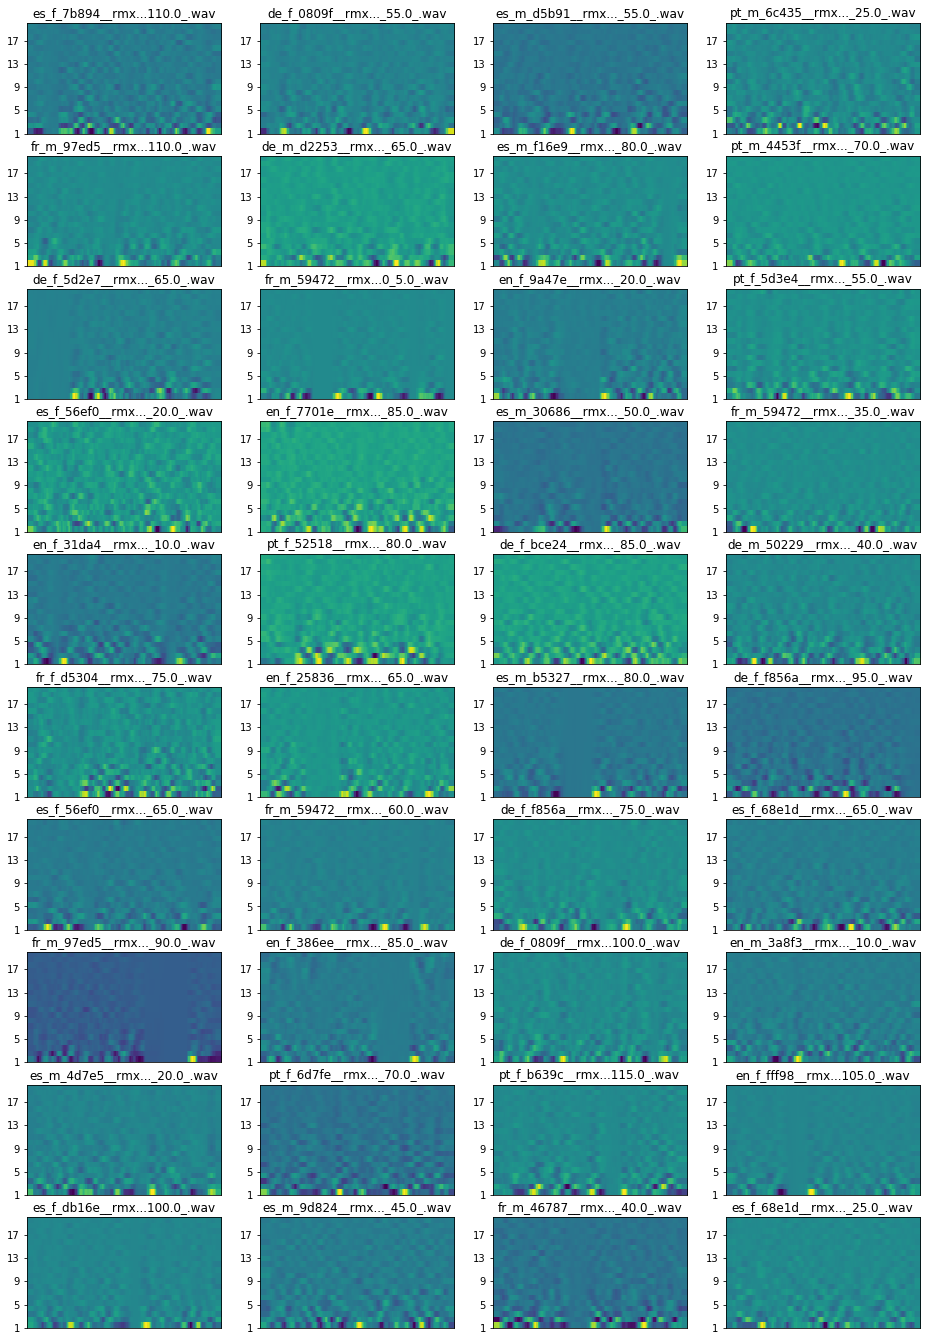

In [39]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [40]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

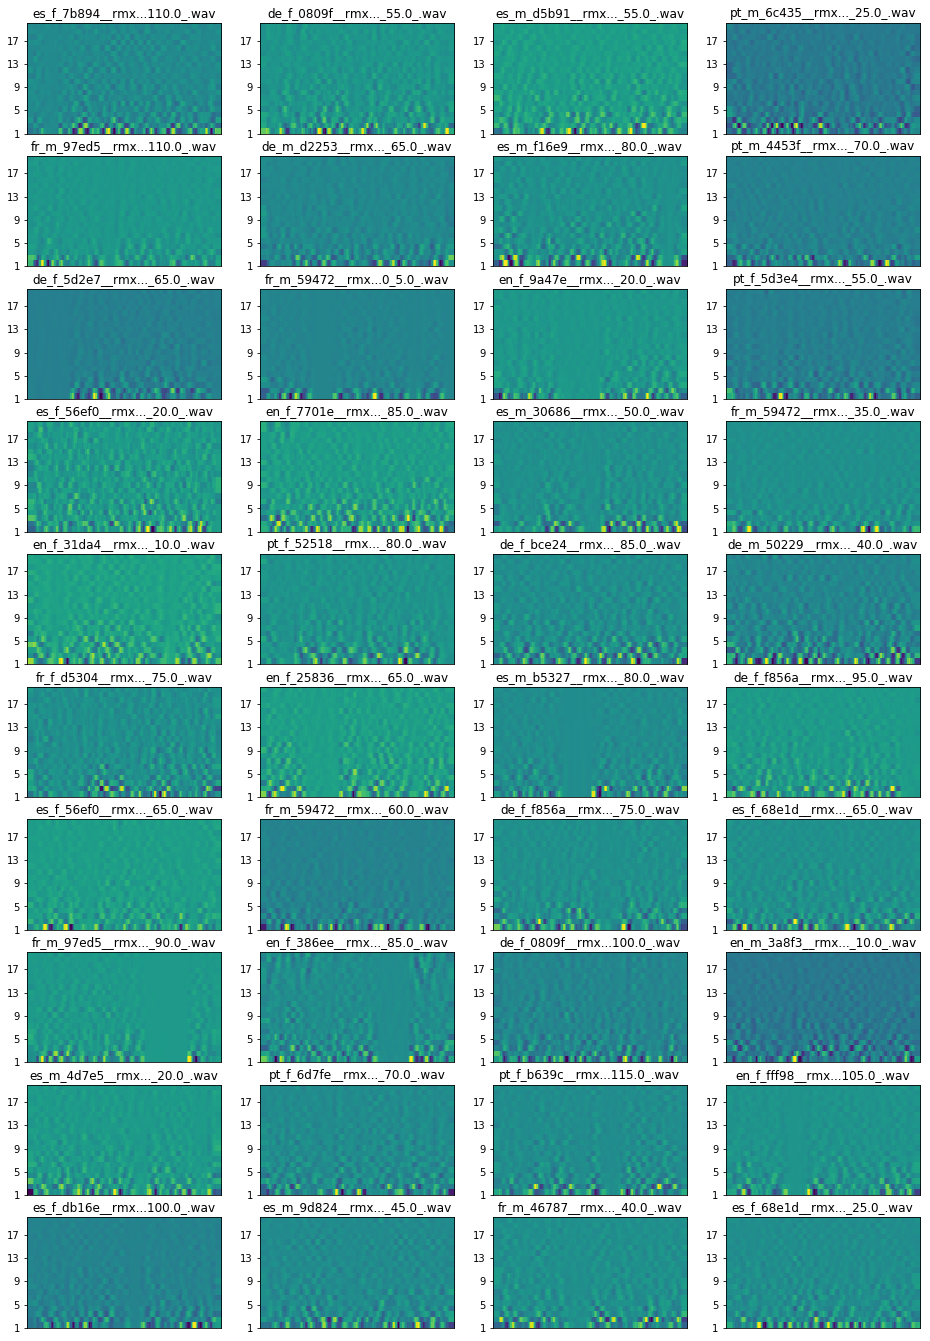

In [41]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

## Mel Spectrogram

In [42]:
def mel_specgram(audio, sample_rate, nframes):
    spec = librosa.feature.melspectrogram(np.asarray(audio, dtype='Float64'), 
                                          sample_rate)
    times = np.linspace(0, nframes/sample_rate, spec.shape[0])
    freqs = np.linspace(1, spec.shape[1], spec.shape[1])
    return freqs, times, spec

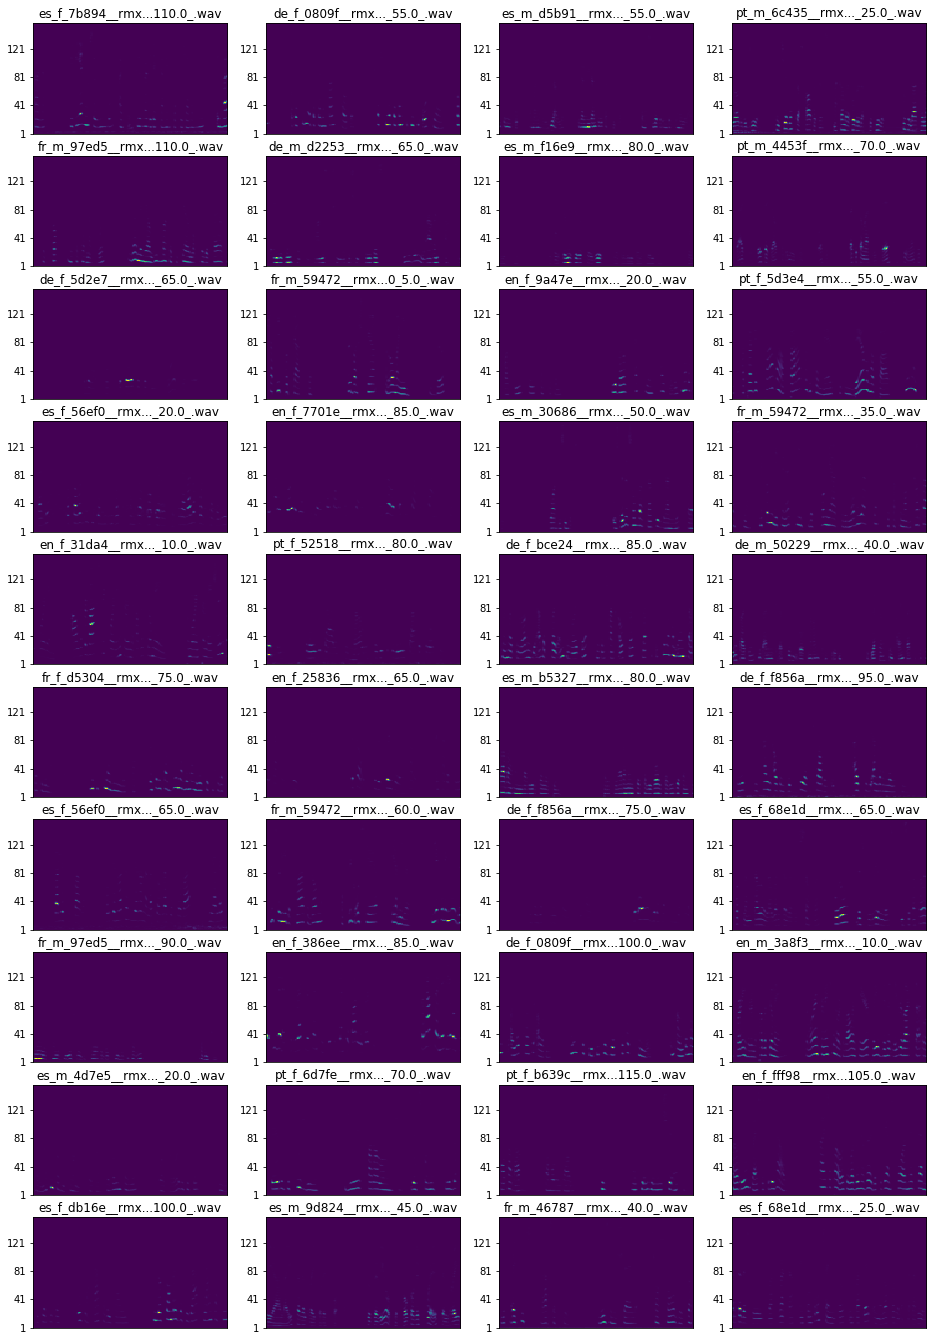

In [43]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mel_specgram(samples['time_series'][idx], sr,
                                             samples['nframes'][idx])
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMelSpecs-{}-{}".format(DATASET, GROUP), dpi=900)  